# 前言
数据集是台湾某银行 2005 年 4 月到 9 月的信用卡数据，客户的行为分为违约和守约。 

本项目是要针对这个数据集构建一个分析信用卡违约率的分类器，采用的算法包括 SVM(支持向量机)、决策树、KNN(k近邻) 分类器，以及随机森林分类器，并比较各算法的准确率。

In [1]:
import pandas as pd
pd.set_option('display.max_columns',None)  # 显示所有列
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']  # 图表正常显示中文
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV  # 数据拆分、参数调优
from sklearn.preprocessing import StandardScaler  # 规范化
from sklearn.pipeline import Pipeline  # 管到机制
from sklearn.metrics import accuracy_score  # 评估哈数
from sklearn.svm import SVC  # 支持向量机
from sklearn.tree import DecisionTreeClassifier  # 决策树分类
from sklearn.neighbors import KNeighborsClassifier  # KNN
from sklearn.ensemble import RandomForestClassifier  # 随机森林分类


Bad key "text.kerning_factor" on line 4 in
D:\Program Files (x86)\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## 数据探索

In [2]:
data = pd.read_csv(r"UCI_Credit_Card.csv")
data.head(10)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
5,6,50000.0,1,1,2,37,0,0,0,0,0,0,64400.0,57069.0,57608.0,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0
6,7,500000.0,1,1,2,29,0,0,0,0,0,0,367965.0,412023.0,445007.0,542653.0,483003.0,473944.0,55000.0,40000.0,38000.0,20239.0,13750.0,13770.0,0
7,8,100000.0,2,2,2,23,0,-1,-1,0,0,-1,11876.0,380.0,601.0,221.0,-159.0,567.0,380.0,601.0,0.0,581.0,1687.0,1542.0,0
8,9,140000.0,2,3,1,28,0,0,2,0,0,0,11285.0,14096.0,12108.0,12211.0,11793.0,3719.0,3329.0,0.0,432.0,1000.0,1000.0,1000.0,0
9,10,20000.0,1,3,2,35,-2,-2,-2,-2,-1,-1,0.0,0.0,0.0,0.0,13007.0,13912.0,0.0,0.0,0.0,13007.0,1122.0,0.0,0


字段及含义

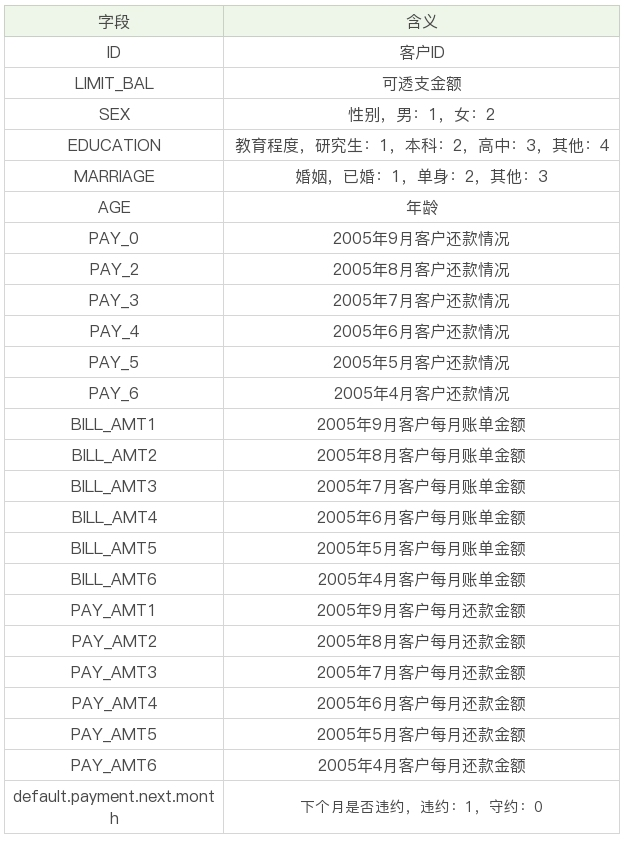

In [3]:
data.shape

(30000, 25)

In [4]:
data.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [5]:
data['default.payment.next.month'].value_counts()

0    23364
1     6636
Name: default.payment.next.month, dtype: int64

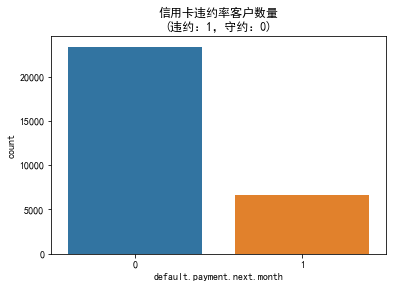

In [6]:
# 将违约率结果可视化
plt.title('信用卡违约率客户数量\n(违约：1，守约：0)')
sns.countplot(data['default.payment.next.month'], label='count')

## 特征选择

In [7]:
# 去掉ID字段
data.drop(['ID'], inplace=True, axis=1)

# 目标矩阵
target = data['default.payment.next.month'].values

columns = data.columns.tolist()
columns.remove('default.payment.next.month')  # 删除列表特定元素

# 特征矩阵
features = data[columns].values

## 准备训练集和测试集

In [8]:
# 抽取30%的数据作为测试集，其余作为训练集，测试集和训练集中，违约和守约的比例跟总数据一样
train_x, test_x, train_y, test_y = train_test_split(features,
                                                    target,
                                                    test_size=0.3,
                                                    stratify=target,  # 按照target中的比例分配
                                                    random_state=1)

## 构造各种分类器

In [9]:
# 构造4种分类器：支持向量机、决策树、随机森林、KNN
classifiers = [SVC(random_state=1, kernel='rbf'),   # rbf高斯核函数
               DecisionTreeClassifier(random_state=1, criterion='gini'),  # 基尼系数
               RandomForestClassifier(random_state=1, criterion='gini'),  # 基尼系数
               KNeighborsClassifier(metric='minkowski')]  # 距离度量默认闵可夫斯基距离

# 分类器名称
classifier_names = ['svc',
                    'decisiontreeclassifier',
                    'randomforestclassifier',
                    'kneighborsclassifier']

# 分类器参数
classifier_param_grid = [{'svc__C': [1], 'svc__gamma':[0.01]},
                         {'decisiontreeclassifier__max_depth': [6, 9, 11]},
                         {'randomforestclassifier__n_estimators': [3, 5, 6]},
                         {'kneighborsclassifier__n_neighbors': [4, 6, 8]}]

## 对具体的分类器进行 GridSearchCV 参数调优

In [10]:
# 定义函数，对具体的分类器进行 GridSearchCV 参数调优
def GridSearchCV_work(pipeline, train_x, train_y, test_x, test_y, param_grid, score='accuracy'):
    response = {}
    gridsearch = GridSearchCV(
        estimator=pipeline, param_grid=param_grid, scoring=score)

    # 寻找最优的参数 和最优的准确率分数
    search = gridsearch.fit(train_x, train_y)
    print('GridSearch 最优参数：{}'.format(search.best_params_))
    print('GridSearch 最优分数：{:.4f}'.format(search.best_score_))

    predict_y = gridsearch.predict(test_x)
    print('准确率：{:.4f}\n'.format(accuracy_score(test_y, predict_y)))

    response['predict_y'] = predict_y
    response['accuracy_score'] = accuracy_score(test_y, predict_y)

    return response

## 使用 Pipeline 管道机制进行流水线作业

In [11]:
for model, model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid):
    pipeline = Pipeline([('scaler', StandardScaler()),
                         (model_name, model)])
    result = GridSearchCV_work(
        pipeline, train_x, train_y, test_x, test_y, model_param_grid, score='accuracy')

GridSearch 最优参数：{'svc__C': 1, 'svc__gamma': 0.01}
GridSearch 最优分数：0.8186
准确率：0.8172

GridSearch 最优参数：{'decisiontreeclassifier__max_depth': 6}
GridSearch 最优分数：0.8208
准确率：0.8113

GridSearch 最优参数：{'randomforestclassifier__n_estimators': 6}
GridSearch 最优分数：0.8004
准确率：0.7994

GridSearch 最优参数：{'kneighborsclassifier__n_neighbors': 8}
GridSearch 最优分数：0.8040
准确率：0.8036



我们能看到 SVM 分类器的准确率最高，测试准确率为 0.8172。  
在决策树分类中，设置了[6,9,11] 3 种最大深度，当最大深度为 6 时结果最优，测试准确率为 0.8113；  
在随机森林分类中，设置了[3,5,6] 3 个决策树个数的取值，取值为 6 时结果最优，测试准确率为 0.7994；  
在 KNN 分类中，设置了[4,6,8] 3 个 n 的取值，取值为 8 时结果最优，测试准确率为 0.8036。

# 总结
在这个项目里，我们对信用卡数据集进行分类预测，采用了4种算法：SVM(支持向量机)、决策树、KNN(k近邻)分类器，随机森林分类器。除了 SVM 外，其他3种算法的参数取值范围很广，我们可以不断更改参数进行参数优化，但这样处理效率比较低。解决方案是采用 GridSearchCV 工具，在我们定义好备选参数后，GridSearchCV 函数会把备选参数对应的模型都运行一遍，从而选出备选参数里的最优参数，使得模型预测分数最高；  

另外，分类算法的步骤都类似，比如先进行数据规范化处理，再构建分类算法。Pipeline 管道机制，可以把步骤封装起来，可以实现每一个步骤按顺序进行，创建流水线作业，可以简化代码，提高效率。  

最后，每一个算法都找到最优参数并按照既定步骤运行完，我们可以得出结论：本项目里 SVM 分类器的准确率最高，为 81.72%，意味着其他的用户数据，通过这个模型进行分类预测，我们有 81.72% 准确率可以预测出来他是否是欺诈用户。